# Point Pattern Analysis

In [4]:
%matplotlib inline

import numpy
import pandas
import geopandas
from shapely.geometry import Point, MultiPoint
import pysal
import seaborn
import contextily
import matplotlib.pyplot as plt
from sklearn.cluster import dbscan

## Introduction

Points are spatial entities that can be understood in two fundamentally different ways. On the one hand, points can be seen as fixed objects in space, which is to say their location is taken as given (*exogenous*). In this interpretation, the location of an observed point is considered as secondary to the value observed at the point. Think of this like measuring the number of cars traversing a given road intersection; the location is fixed, and the data of interest comes from the measurement taken at that location. The analysis of this kind of point data is very similar to that of other types of spatial data such as polygons and lines. On the other hand, an observation occuring at a point can also be thought of as a site of measurement from an underlying geographically-continuous process. In this case, the measurement could theoretically take place anywhere, but was only carried out or conducted in certain locations. Think of this as measuring the length of birds' wings: the location at which birds are measured reflects the underlying geographical process of bird movement and foraging, and the length of the birds' wings may reflect an underlying ecological process that varies by bird. This kind of approach means that both the location and the measurement matter. This is the perspective we will adopt in the rest of the chapter.

When points are seen as events that could take place in several locations but only happen in a few of them, a collection of such events is called a *point pattern*. In this case, the location of points is one of the key aspects of interest for analysis. A good example of a point pattern is crime events in a city: they could technically happen in many locations but we usually find crimes are committed only in a handful of them. Point patterns can be *marked*, if more attributes are provided with the location, or *unmarked*, if only the coordinates of where the event occured are provided. Continuing the crime example, an unmarked pattern would result if only the location where crimes were committed was used for analysis, while we would be speaking of a marked point pattern if other attributes, such as the type of crime, the extent of the damage, etc. was provided with the location.

Point pattern analysis is thus concerned with the visualization, description, statistical characerization, and modeling of point patterns, focusing specially on the generating process that gives rise and explains the observed data. Common questions in this domain include
- *What does the pattern look like?* 
- *What is the nature of the distribution of points?* 
- *Is there any structure in the way locations are arranged over space? That is, are events clustered? or are they dispersed?*
- *Why do events occur in those places and not in others?* 
These are the most common questions in the analysis of point patterns. 

At this point, it is useful to remind ourselves of an important distinction, that between process and pattern. The former relates to the underlying mechanism that is at work to generate the outcome we end up observing. Because of its abstract nature, we do not get to see it. However, in many contexts, the key focus of any analysis is to learn about *what* determines a given phenomenon and *how* those factors combine to generate it. In this context, "process" is associated with the *how*. "Pattern," on the other hand, relates to the result of that process. In some cases, it is the only trace of the process we can observe and thus the only input we have to work with in order to reconstruct it. Although directly observable and, arguably, easier to tackle, pattern is only a reflection of process. The real challenge in many applications is not to characterize the former but to use it to work out the latter.

In this chapter, we will focus on an introduction to point patters through geo-tagged Flickr photos from Tokyo. In this case, we will treat the phenomena represented in the data as events: photos could be taken of any place in Tokyo, but only certain locations are captured. Keep in mind this understanding of Tokyo photos is not immutable: one could conceive cases where it makes sense to take those locations as given and look at the properties of each of them ignoring their "event" aspect. However, in this context, we will focus on those questions that relate to location and the collective shape of locations. The use of these tools will allow us to transform a long list of unintelligible XY coordinates into tangible phenomena with a characteristic spatial structure, and to answer questions about the center, dispersion, and clustering of attractions in Tokyo for Flickr users.

## Location, Location, Location

The rise of new forms of data such as geotagged photos uploaded to online services is creating new ways for researchers to study and understand cities. Where to people take pictures? When are those pictures taken? Why certain places attract many more photographers than others? All these questions and more become more than just rethorical ones when we consider volunteered geographic information (VGI, [Goodchild, 2007](https://link.springer.com/article/10.1007%2Fs10708-007-9111-y)) in the form of online photo hosting services. In this vignette we will explore metadata from a sample of georeferenced images uploaded to [Flickr](https://www.flickr.com/) and extracted thanks to the [100m Flickr dataset](https://webscope.sandbox.yahoo.com/catalog.php?datatype=i&did=67). To do that, we will introduce a few approaches that help us better understand the distribution and characteristics of a point pattern. To get started, let's load the flickr data first:

In [5]:
db = pandas.read_csv('../data/tokyo_clean.csv')

This table has been lightly processed from the raw data. It contains the user ID, the latitude and longitude, as well as those coordinates expressed in Pseudo Mercator, the timestamp when the photo was taken, and the url of the picture they refer to:

In [6]:
db.head()

user_id   longitude   latitude             date_taken  \
0     10727420@N00  139.700499  35.674000  2010-04-09 17:26:25.0   
1      8819274@N04  139.766521  35.709095  2007-02-10 16:08:40.0   
2     62068690@N00  139.765632  35.694482  2008-12-21 15:45:31.0   
3  49503094041@N01  139.784391  35.548589  2011-11-11 05:48:54.0   
4     40443199@N00  139.768753  35.671521  2006-04-06 16:42:49.0   

                                photo/video_page_url             x  \
0  http://www.flickr.com/photos/10727420@N00/4545...  1.555139e+07   
1  http://www.flickr.com/photos/8819274@N04/26503...  1.555874e+07   
2  http://www.flickr.com/photos/62068690@N00/3125...  1.555864e+07   
3  http://www.flickr.com/photos/49503094041@N01/6...  1.556073e+07   
4  http://www.flickr.com/photos/40443199@N00/2482...  1.555899e+07   

              y  
0  4.255856e+06  
1  4.260667e+06  
2  4.258664e+06  
3  4.238684e+06  
4  4.255517e+06

### Visualization

The first step to get a sense of what the spatial dimension of this dataset looks like is to plot it. At its most basic level, we can generate a scatter plot with a single line:

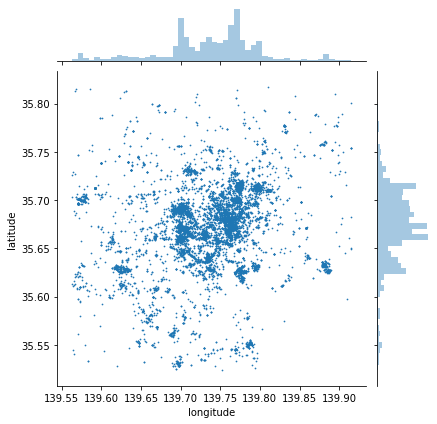

In [7]:
# Generate scatter plot
seaborn.jointplot(x='longitude', y='latitude', data=db, s=0.5);

This is a good start: we can see dots tend to be concentrated in the center of the covered area in a very (apparently) not random. Furthermore, within the broad pattern, we can also see there seems to be more localised clusters. However, the plot above has two key drawbacks: one, it lacks geographical context; and two, there are areas where the density of points is so large that it is hard to tell anything beyond a blue blurb. 

Start with the context. The easiest way to provide additional context is by ovelaying a tile map from the internet. Let us quickly call `contextily` for that. We first obtain the bounding box of the point pattern.

In [8]:
# Extract bounding box from the `x` and `y` columns
bounding_box = [db.x.min(), db.y.min(), db.x.max(), db.y.max()]

Then, we can pull the tiles down using `contextily.bounds2img`:

In [9]:
# Download map tiles
basemap, basemap_extent = contextily.bounds2img(*bounding_box, zoom=11,
                                                url = contextily.tile_providers.ST_TONER_LITE)

Now, `basemap` is an array containing the raw image data for a basemap of Tokyo, and the `extent` is the boundary of that image, in terms of the same pseudo-Mercator projection the data uses. However, it is important to note that many of the mapping tools in spatial analysis express their bounding box in **corner form**:
```
left, bottom, right, top
```
This is **corner form** because it stitches together the locations of the bottom-left and top-right of the map. Despite the geographic analysis tools' focus on corner-form bounds, many of the *plotting* tools in Python express their bounding box in an **edge form**, stitching together the left & right edges with the bottom & top edges:
```
left, right, bottom, top
```
This can be confusing. We will be consistent in referring to a **corner form** boundary as a `bounding_box`, whereas an `extent` will refer to an **edge form** boundary. 

You can see this practically by comparing our original `bounding_box` to the `basemap_extent` returned from `contextily`. Since the `basemap_extent` is used in plotting, it is in edge form. But, since `contextily` takes its input from geographical data, it expects a `bounding_box` in corner form, as input. 

In [10]:
bounding_box

[15536078.976635901, 4235240.756448597, 15575297.38983982, 4275538.623192449]

In [11]:
basemap_extent

(15517328.23811706, 15576031.875840075, 4226661.916057105, 4285365.553780119)

For convenience, sometime is it also helpful to define the `data_extent` as well, in case the basemap covers too much additional area:

In [12]:
data_extent = [db.x.min(), db.x.max(), db.y.min(), db.y.max()]

#### Dots on a map

Together, adding a basemap to our initial plot really makes the pattern of Flickr data clearer:

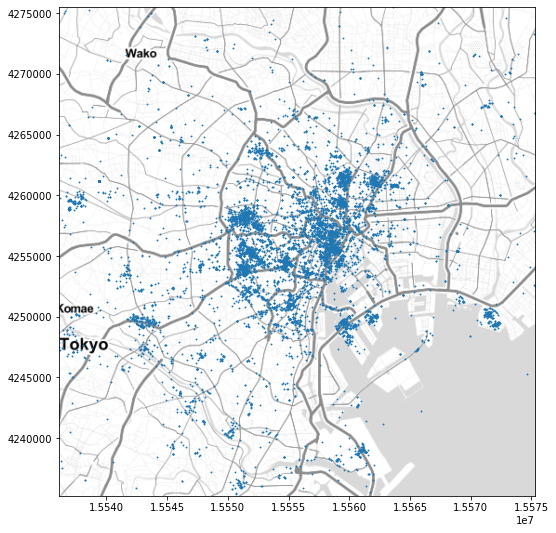

In [54]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Add map tiles for context
ax.imshow(basemap, extent=basemap_extent, 
          interpolation='bilinear')
# Plot photograph points
ax.scatter(db['x'], db['y'], s=0.75)
ax.axis(data_extent)
# Display
plt.show()

#### Hex-binning

Let us now take care of the second problem. When some areas of town have too many dots, plotting opaque dots on top of one another can make it hard to tell any pattern or see through to explore the characteristics of the area. For example, in the middle of the map, towards the right, there is the highest concentration of pictures taken; this sheer amount of dots on the maps in some parts obscures whether all of that area receives as many pics or whether, within there, some places receive a particularly high degree of attention.

The first solution for this, which has become very popular in the last few years, is a *spatial* or *2-dimensional histogram*. Here, we generate a regular grid (either squared or hexagonal), count how many dots fall within each grid cell, and present it as we would any other choropleth. This is attractive because it is simple, intuitive, and the regular grid removes some of the area distortions choropleths may induce. We will use hexagonal binning (sometimes called hexbin) because it has slightly nicer properties than squared grids, such as larger flexibility in the shape and better connectivity between cells. Creating a hexbin 2-d histogram is straightforward in Python using the `hexbin` function:

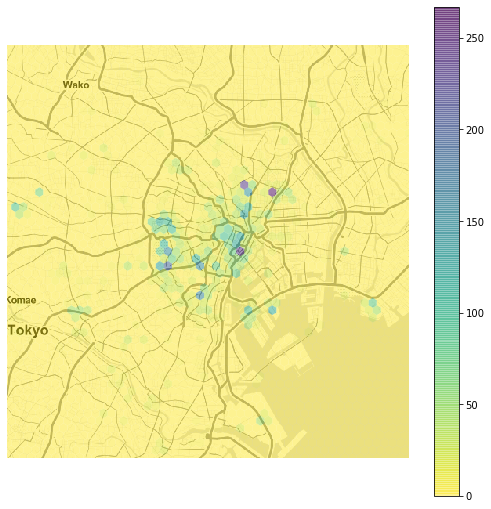

In [38]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Add map tiles for context
ax.imshow(basemap, extent=basemap_extent, interpolation='bilinear')
# Generate and add hexbin with 50 hexagons in each 
# dimension, no borderlines, half transparency,
# and the reverse viridis colormap
hb = ax.hexbin(db['x'], db['y'],
               gridsize=50, linewidths=0,
               alpha=0.5, cmap='viridis_r')
ax.axis(data_extent)
# Add colorbar
plt.colorbar(hb)
# Remove axes
ax.set_axis_off()

Voila, this allows a lot more detail! It is now clear that the majority of photographs relate to much more localised areas and that the previous map was obscuring this.

#### Kernel Density Estimation (KDE)

Grids are the spatial equivalent of a histogram: the user decides how many "buckets", and the points are counted within them in a discrete fashion. This is fast, efficient, and potentially very detailed (if many bins are created). However, it does represent a discretisation of an essentially contiguous phenomenon and, as such, it may introduce distortions (e.g. MAUP). An alternative approach is to instead create what is known as a kernel density estimation (KDE): an empirical approximation of the probability density function. This approach is covered in detail elsewhere (e.g. [Silverman 1986](https://books.google.co.uk/books?hl=en&lr=&id=e-xsrjsL7WkC&oi=fnd&pg=PR9&dq=Silverman,+B.+W.+(1986)&ots=ixJrnv0GXo&sig=pMOnWU2UYmJ5SYpGWsnXtBgS_LI#v=onepage&q=Silverman%2C%20B.%20W.%20(1986)&f=false)), but we can provide the intuition here. Instead of overlaying a grid of squares of hexagons and count how many points fall within each, a KDE lays a grid of points over the space of interest on which it places kernel functions that count points around them with different weight based on the distance. These counts are then aggregated to generate a global surface with probability. The most common kernel function is the gaussian one, which applies a normal distribution to weight points. The result is a continuous surface with a probability function that may be evaluated at every point. Creating a gaussian kernel in Python is rather straightfoward:

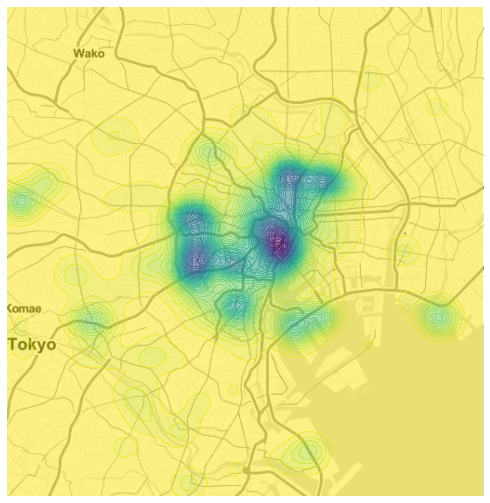

In [39]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Add map tiles for context
ax.imshow(basemap, extent=basemap_extent, interpolation='bilinear')
# Generate and add KDE with a shading of 50 gradients 
# coloured contours, 75% of transparency,
# and the reverse viridis colormap
seaborn.kdeplot(db['x'], db['y'],
                n_levels=50, shade=True,
                alpha=0.55, cmap='viridis_r')
# Remove axes
ax.axis(data_extent)
ax.set_axis_off()

The result is a much smoother output that captures the same structure of the hexbin but eases the transitions between different areas. This provides a better generalisation of the theoretical probability that a picture *might* occur at any given point. This is useful in some cases, but is mainly of use to escape the restrictions imposed by a regular grid of hexagons or squares. 

### Centrography

Centrography is the analysis of centrality in a point pattern. By "centrality," we mean the general location and dispersion of the pattern. Many different measures are used in centrography to provide an indication of "where" a point pattern is, how tightly the point pattern clusters around its center, or how irregular its shape is. 

For instance, one common measure of central tendency for a point pattern is its *center of mass*. For marked point patterns, the center of mass identifies a central point close to observations that have higher values in their marked attribute. For unmarked point patterns, the center of mass is equivalent to the *mean center*, or average of the coordinate values. In addition, the *median center* is analogous to the *median* elsewhere, and represents a point where half of the data is above or below the point & half is to its left or right. We can analyze the mean center with our flickr point pattern using the `pointpats` package in Python. 

In [50]:
from pointpats import centrography

In [60]:
mean_center = centrography.mean_center(db[['x', 'y']])
med_center = centrography.euclidean_median(db[['x', 'y']])

It is easiest to visualize this by plotting the point pattern and its mean center alongside one another:

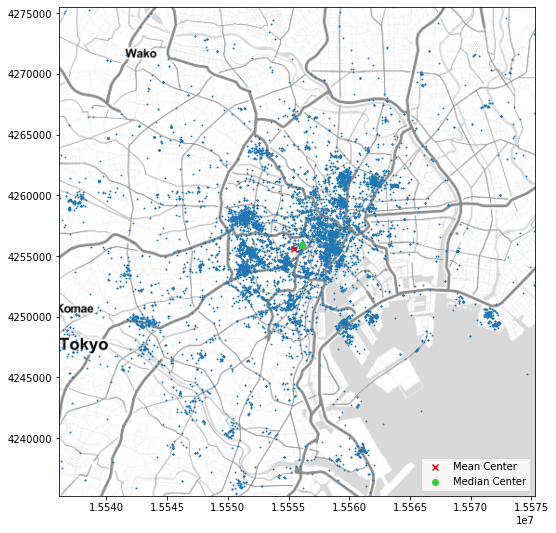

In [64]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Add map tiles for context
ax.imshow(basemap, extent=basemap_extent, 
          interpolation='bilinear')
# Plot photograph points
ax.scatter(db['x'], db['y'], s=0.75)
ax.scatter(*mean_center, color='red', marker='x', label='Mean Center')
ax.scatter(*med_center, color='limegreen', marker='o', label='Median Center')
ax.axis(data_extent)
ax.legend()
# Display
plt.show()

The discrepancy between the two centers is caused by the skew; there are many "clusters" of pictures far out in West& South Tokyo, whereas North & East Tokyo is densely packed, but drops off very quickly. Thus, the far out clusters of pictures pulls the mean center to the west and south, relative to the median center. 

A measure of dispersion that is common in centrography is the *standard distance*. This measure provides the average distance away from the center of the point cloud (such as measured by the center of mass). This is also simple to compute using `pointpats`, using the `std_distance` function:

In [72]:
centrography.std_distance(db[['x','y']])

8778.218566162072

This means that, on average, pictures are taken around 8800 feet away from the mean center. 

Another helpful visualization is the *standard deviational ellipse*, or *standard ellipse*. This is an ellipse drawn from the data that reflects both its center and dispersion. To visualize this, we first compute the axes and rotation using the `ellipse` function in `pointpats`:

In [76]:
major, minor, rotation = centrography.ellipse(db[['x','y']])

In [77]:
from matplotlib.patches import Ellipse

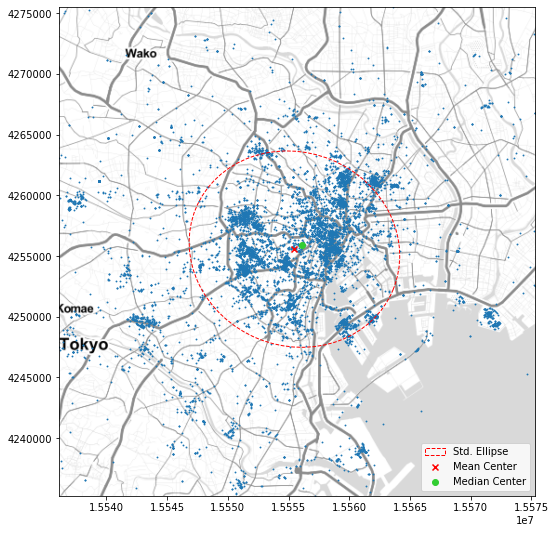

In [111]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Add map tiles for context
ax.imshow(basemap, extent=basemap_extent, 
          interpolation='bilinear')
# Plot photograph points
ax.scatter(db['x'], db['y'], s=0.75)
ax.scatter(*mean_center, color='red', marker='x', label='Mean Center')
ax.scatter(*med_center, color='limegreen', marker='o', label='Median Center')
ellipse = Ellipse(xy=mean_center, 
                  width=major*2, # centrography.ellipse gives half the axis!
                  height=minor*2, 
                  angle = numpy.rad2deg(rotation), 
                  facecolor='none', 
                  edgecolor='red', linestyle='--',
                  label='Std. Ellipse')
ax.add_patch(ellipse)

ax.axis(data_extent)
ax.legend()
# Display
plt.show()

Finally, another collection of measures about point patterns characterize the extent of a point cloud. Four shapes are useful, and reflect varying levels of how "tightly" they bind the pattern. In order of tightness:

1. The **minimum alpha shape** reflects the tightest polygon that can be drawn around the data that contains all of the points. This is implemented, for instance, in the `libpysal.cg` module.
2. The **convex hull** reflects the tightest *convex* polygon that can be drawn around the data that contains all of the points. By *convex*, we mean that the shape never "doubles back" on itself; it has no divets, valleys, crenelations, or holes. All of its interior angles are smaller than 180 degrees. 
3. The **minimum bounding rectangle** reflects the tightest *rectangle* that can be drawn around the data that contains all of the points. In `pointpats`, this is computed using the `mbr` function and is the "straight" rectangle, meaning it is not rotated. However, this rectangle can often be *rotated* to achieve a smaller area. This **minimum rotated rectangle** provides a tighter rectangular bound on the point pattern. (While the minimum rotated rectangle is not currently implemented in `pointpats`, it is implemented in common python packages, such as `OpenCV`'s `cv.minAreaRect` function.)
4. The **minimum bounding circle** is the smallest circle that can be drawn to enclose the entire dataset. Often, this circle is bigger than the minimum bounding rectangle. This tends to be somewhat more computationally challenging than the minimum rotated rectangle, and is implemented in the `skyum` function in `pointpats`. 

To show how to compute all of these, we can compute them each using their functions:

In [119]:
#from cv import minAreaRect as minimum_rotated_rectangle
from libpysal.cg import alpha_shape_auto

In [123]:
coordinates = db[['x','y']].values
alpha_shape = alpha_shape_auto(coordinates)

NameError: name 'centrograpy' is not defined

In [170]:
convex_hull = centrography.hull(coordinates)
min_rect = centrography.mbr(coordinates)
#min_rot_rect = minimum_rotated_rectangle(coordinates)
(min_circ_r,min_circ_center), *_ = centrography.skyum(coordinates)

In [164]:
from matplotlib.patches import Circle, Rectangle, Polygon

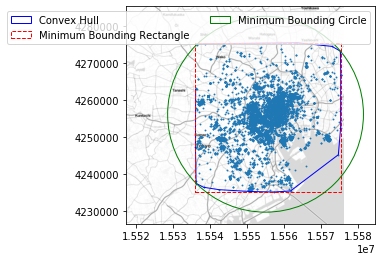

In [194]:
f,ax = plt.subplots(1)
ax.imshow(basemap, extent=basemap_extent, interpolation='bilinear')
ch = Polygon(convex_hull, closed=False, edgecolor='blue', facecolor='none', 
             label='Convex Hull')
rect = Rectangle(min_rect[0:2], width=min_rect[2] - min_rect[0], 
                 height = min_rect[3] - min_rect[1],
                 edgecolor='r', facecolor='none', 
                 label='Minimum Bounding Rectangle', linestyle='dashed')
circ = Circle(min_circ_center, radius=min_circ_r,
              edgecolor='green', facecolor='none', 
              label='Minimum Bounding Circle')
ax.add_patch(ch)
ax.add_patch(rect)
ax.add_patch(circ)
ax.scatter(db.x, db.y, s=.75)
ax.legend(ncol=2)
plt.show()

### Testing for non-randomness

- quadrat
- distance based
- k-functions
- bi-variate k

### Identifying clusters

In this final section, we will learn a method to identify clusters of points, based on their density across space. To do this, we will use the widely used `DBSCAN` algorithm. For this method, a cluster is a concentration of at least `m` points, each of them within a distance of `r` of at least another point in the cluster. Points in the dataset are then divided into three categories:

* *Noise*, for those points outside a cluster.
* *Cores*, for those points inside a cluster whith at least `m` points in the cluster within distance `r`.
* *Borders* for points inside a cluster with less than `m` other points in the cluster within distance `r`.

Both `m` and `r` need to be prespecified by the user before running `DBSCAN`. This is a critical point, as their value can influence significantly the final result. Before exploring this in greater depth, let us get a first run at computing `DBSCAN` in Python.

In [26]:
# Compute DBSCAN
cs, lbls = dbscan(db[['x', 'y']])

The function returns two objects, which we call `cs` and `lbls`. `cs` contains the indices (order, starting from zero) of each point which is classified as a *core*. We can have a peek into it to see what it looks like:

In [27]:
# Print the first 5 elements of `cs`
cs[:5]

array([ 1, 22, 30, 36, 42])

The printout above tells us that the second (remember, Python starts counting at zero!) point in the dataset is a core, as it is the 23rd, 31st, 36th, and 43rd. The object `cs` always has a variable length, depending on how many cores the algorithm finds.

Now let us have a look at `lbls`, short for labels:

In [28]:
lbls[:5]

array([-1,  0, -1, -1, -1])

The labels object always has the same length as the number of points used to run `DBSCAN`. Each value represents the index of the cluster a point belongs to. If the point is classified as *noise*, it receives a -1. Above, we can see that the second point belongs to cluster 1, while the others in the list are effectively not part of any cluster. To make thinks easier later on, let us turn `lbls` into a `Series` object that we can index in the same way as our collection of points:

In [29]:
lbls = pd.Series(lbls, index=db.index)

Now we already have the clusters, we can proceed to visualize them. There are many ways in which this can be done. We will start just by coloring points in a cluster in red and noise in grey:

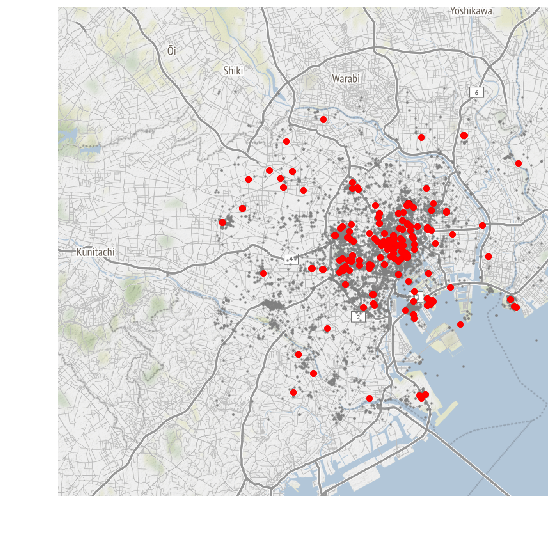

In [30]:
# Setup figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Add base layer with tiles for context
ax.imshow(img, extent=ext, alpha=0.75)
# Subset points that are not part of any cluster (noise)
noise = db.loc[lbls==-1, ['x', 'y']]
# Plot noise in grey
ax.scatter(noise['x'], noise['y'], c='grey', s=5, linewidth=0)
# Plot all points that are not noise in red
# NOTE how this is done through some fancy indexing, where
#      we take the index of all points (tw) and substract from
#      it the index of those that are noise
ax.scatter(db.loc[db.index.difference(noise.index), 'x'], \
           db.loc[db.index.difference(noise.index), 'y'], \
          c='red', linewidth=0)
# Remove axes
ax.set_axis_off()
# Display the figure
plt.show()

Although informative, the result of this run is not particularly satisfactory. XXX. This is because we have run `DBSCAN` with the default parameters. If you type `dbscan?`, you will get the help of the function and will be able to see what those are: a radious of 0.5 and a minimum of five points per cluster. Since our data is expressed in metres, a radius of half a metre will only pick up hyper local clusters. This might be of interest in some cases but, in others, it can result in odd outputs. 

Let us change those parameters to see if we can pick up more general patterns. For example, let us say a cluster needs to, at least, have roughly 1% of all the points in the dataset:

In [31]:
# Obtain the number of points 1% of the total represents
minp = np.round(db.shape[0] * 0.01)
minp

100.0

At the same time, let us expand the maximum radious to say, 500 metres. Then we can re-run the algorithm and plot the output, all in the same cell this time:

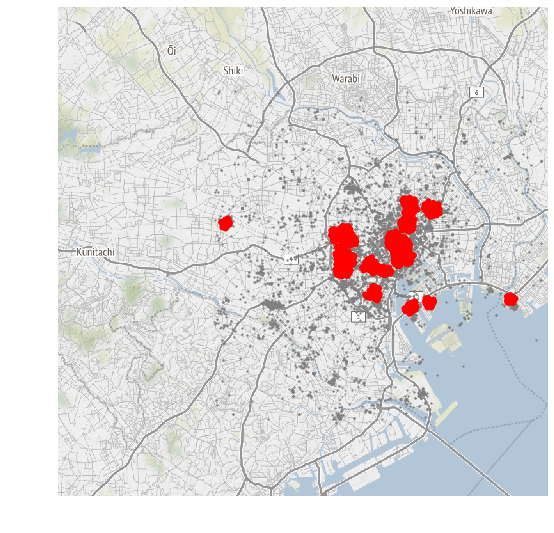

In [32]:
# Rerun DBSCAN
cs, lbls = dbscan(db[['x', 'y']], eps=500, min_samples=minp)
# Turn labels into a Series
lbls = pd.Series(lbls, index=db.index)

# Setup figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Add base layer with tiles for context
ax.imshow(img, extent=ext, alpha=0.75)
# Subset points that are not part of any cluster (noise)
noise = db.loc[lbls==-1, ['x', 'y']]
# Plot noise in grey
ax.scatter(noise['x'], noise['y'], c='grey', s=5, linewidth=0)
# Plot all points that are not noise in red
# NOTE how this is done through some fancy indexing, where
#      we take the index of all points (tw) and substract from
#      it the index of those that are noise
ax.scatter(db.loc[db.index.difference(noise.index), 'x'], \
           db.loc[db.index.difference(noise.index), 'y'], \
          c='red', linewidth=0)
# Remove axes
ax.set_axis_off()
# Display the figure
plt.show()

- Convex hull (`shapely`) of each cluster

In [33]:
chs = []
for cID in lbls.unique():
    if cID != -1:
        cluster = db.loc[lbls==cID]
        geom = cluster.loc[:, ['x', 'y']].apply(\
                                    lambda xy: Point(*xy), axis=1
                                               )
        ch = MultiPoint(geom.tolist()).convex_hull
        chs.append(ch)
chs = gpd.GeoSeries(chs)

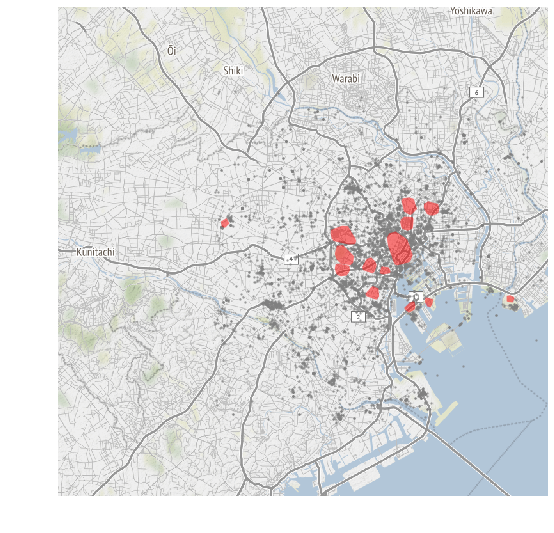

In [34]:
# Rerun DBSCAN
cs, lbls = dbscan(db[['x', 'y']], eps=500, min_samples=minp)
# Turn labels into a Series
lbls = pd.Series(lbls, index=db.index)

# Setup figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Add base layer with tiles for context
ax.imshow(img, extent=ext, alpha=0.75)
# Subset points that are not part of any cluster (noise)
noise = db.loc[lbls==-1, ['x', 'y']]
# Plot noise in grey
ax.scatter(noise['x'], noise['y'], c='grey', s=5, \
           linewidth=0, alpha=0.75)
# Plot convex hulls
chs.plot(ax=ax, color='red', alpha=0.5, linewidth=0.)
# Remove axes
ax.set_axis_off()
# Display the figure
plt.show()

---

<a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-nd/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/">Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 International License</a>.